In [41]:

import numpy as np
import json
import cv2
import json
import os
import random

import matplotlib.pyplot as plt

from src.HydraPose import HydraPose, SEFFPOSE
from src.SkeletonsBridge import SkeletonsBridge
bridge = SkeletonsBridge()


import sys
sys.path.insert(0, '/home/guisoares/soares_repo/MVOR/lib/')

from visualize_groundtruth import create_index, viz2d, plt_imshow, bgr2rgb, plt_3dplot, coco_to_camma_kps, progress_bar


Some functions to make the evaluation process

In [42]:

def hydrapose(img_path):
    img = cv2.imread(img_path)
    persons = hy.estimate3DPose()
    return persons

def getCamMtxFromDataset(data_dict, id):

    # Get focal values
    fx = data_dict['cameras_info']['camParams']['intrinsics'][id]['focallength'][0]
    fy = data_dict['cameras_info']['camParams']['intrinsics'][id]['focallength'][1]

    # Get center values
    cx = data_dict['cameras_info']['camParams']['intrinsics'][id]['principalpoint'][0]
    cy = data_dict['cameras_info']['camParams']['intrinsics'][id]['principalpoint'][1]

    mtx = np.array([[fx, 0, cx],
                    [0, fy, cy],
                    [0, 0, 1]])
    return mtx

def getCamDistFromDataset(data_dict, id):

    # Get distortion array
    dist = np.array(data_dict['cameras_info']['camParams']['intrinsics'][id]['distortion'])
    return dist

def getPersonMediumDist(person1, person2):
    dists = []
    for kpt1, kpt2 in zip(person1, person2):
        dist = np.sqrt(np.sum(np.power(kpt1 - kpt2, 2)))
        dists.append(dist)
    
    dists = np.array(dists)
    mean = np.mean(dists)
    return mean, dists

def getMinimalDist(persons_est, persons_annon):

    # Store
    min_index_list = []
    min_error_per_joint_list = []
    min_mean_error_per_joint_list = []
    # Get the annotation index that results the minimal mean error
    for person_est in persons_est:
        mean_error_list = []
        error_per_joint_list = []
        for person_annon in persons_annon:
            mean_error, error_per_joint = getMinimalDist(person_est, person_annon)
            mean_error_list.append(mean_error)
            error_per_joint_list.append(error_per_joint)
        # Get the index of the minimum error and insert on a list that contains it 
        min_index = np.argmin(mean_error_list)
        min_index_list.append(min_index)
        min_error_per_joint_list.append(error_per_joint_list[min_index])
        min_mean_error_per_joint_list.append(mean_error_list[min_index])
    
    # Certifie that index list has diferent elements, meaning that no estimation has the same annotation
    _, count = np.unique(min_index_list, return_counts = True)
    for c in count:
        if c != 1:
            raise AssertionError("The mapped index list has duplicated elements")

    # Remap annotation to
    persons_annon_remapped = persons_annon[min_index_list]

    return persons_est, persons_annon_remapped, min_mean_error_per_joint_list, min_error_per_joint_list

In [43]:
GT_ANNO_PATH = os.path.join(os.path.expanduser('~'), "soares_repo", "MVOR","annotations/camma_mvor_2018.json")
GT_IMGS_PATH = '/media/guisoares/guisoares-ext-hdd/Datasets/camma_mvor_dataset/'

# load the ground truth annotations
camma_mvor_gt = json.load(open(GT_ANNO_PATH))
anno_2d, anno_3d, mv_paths, imid_to_path = create_index(camma_mvor_gt)


creating index for 2D annotations
done
creating index for 3D annotations
Index creation done


In [44]:
imid_to_path[10010000013]

'day1/cam1/color/000013.png'

In [45]:
# Read a random multi-view image
# imid_3d = random.choice(list(mv_paths.keys()))
imid_3d = "10010000013_10020000013_10030000013"
imids_2d = [int(m) for m in imid_3d.split("_")]
imgs = [cv2.imread(os.path.join(GT_IMGS_PATH, imid_to_path[_p])) for _p in imids_2d]

anns2d = [anno_2d[str(ann)] for ann in imids_2d]
# anno_3d[imgs_ids][person]['keypoint3D']
anns3d = anno_3d[imid_3d]

#anns2d[img][person]['keypoints']
persons2D_ann = []
for i in range(len(anns2d[0])):
    persons2D_ann.append(anns2d[0][i]['keypoints'])
persons2D_ann = np.array(persons2D_ann)
persons2D_ann = persons2D_ann.reshape(-1,10,3)
persons2D_ann = persons2D_ann[:,:,:2]

persons3D_ann = []
for i in range(len(anns3d)):
    persons3D_ann.append(anns3d[i]['keypoints3D'])
persons3D_ann = np.array(persons3D_ann)
persons3D_ann = persons3D_ann.reshape(-1,12,4)
persons3D_ann = persons3D_ann[:,:,:3]

In [46]:
anns3d[0]['keypoints3D']

[-6.981037387811322,
 -43.53614915031096,
 2268.873390569723,
 2.0,
 -15.692065194985052,
 12.715998942406387,
 2403.855749245868,
 2.0,
 159.9509394669758,
 -30.293373676927068,
 2446.035843632019,
 2.0,
 -122.29817518177914,
 -16.583568666524034,
 2451.169874854348,
 2.0,
 125.67592744604417,
 -84.15899430083893,
 2764.7174609936137,
 2.0,
 -138.97220917869828,
 -29.37483799369886,
 2744.704988259221,
 2.0,
 124.48225121206467,
 170.86628644031444,
 2495.63624552701,
 1.0,
 -221.091623402892,
 208.13883018959407,
 2377.228305109249,
 2.0,
 40.017188555320544,
 279.6970633438193,
 2375.5554318490167,
 1.0,
 -223.96941235519145,
 343.5251260577829,
 2213.9431805082013,
 2.0,
 0.8481853058817705,
 329.55469363824824,
 2317.0129250238047,
 1.0,
 -202.92651725959985,
 407.2245017913474,
 2168.917052722269,
 2.0]

In [47]:
print(len(anns2d[1][2]['keypoints']))
print(len(anns3d[0]['keypoints3D']))

30
48


There is some garbage on annotations. In this case all jeypoints are 0 and person_id = -1

In [48]:
anns2d[0][5]

{'keypoints': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'bbox': [226.74285714285713,
  400.45714285714286,
  192.00000000000006,
  79.54285714285713],
 'person_id': -1,
 'person_role': 'clinician',
 'only_bbox': 1,
 'id': 2950}

Starting device with CPU...
(4, 16, 3)


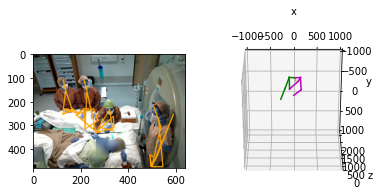

In [49]:
def runHydra():
    hy = HydraPose(pose3D = SEFFPOSE)
    # hy.setIntrinsics(getCamMtxFromDataset(camma_mvor_gt,0),getCamDistFromDataset(camma_mvor_gt,0))
    hy.setIntrinsics(getCamMtxFromDataset(camma_mvor_gt,0), np.array([0.,0.,0.,0.,0.]))
    persons = hy.estimate3DPose(imgs[0])
    persons = persons[:4]
    print(persons.shape)
    persons_aux = np.zeros((persons.shape[0],10,3))
    for idx, person in enumerate(persons):
        persons_aux[idx] = bridge.HM36MtoMVOR(person)
    hy.initWindow()
    hy.viz.ax3D.set_xlim(-1000, 1000)
    hy.viz.ax3D.set_ylim(-1000, 1000)
    hy.viz.ax3D.set_zlim(-200, 2200)
    hy.persons3DHybrid = np.array(persons_aux[1:2])
    hy.plotPersons(imgs[0].copy(), block=False, mode ='MVOR')
    return persons_aux
persons = runHydra()

In [50]:
persons[1,:10]

array([[ 4.24192600e+01, -1.88159101e+01,  2.96679608e+03],
       [ 2.85707518e+01, -5.25141589e+01,  3.10945534e+03],
       [ 1.49163686e+02, -4.93773719e+01,  3.13762809e+03],
       [-1.04149344e+02, -5.78145611e+01,  3.11879707e+03],
       [ 1.05737996e+02,  1.33114658e+02,  3.41320746e+03],
       [-9.86819242e+01,  3.04739223e+02,  3.30232372e+03],
       [ 1.66439711e+02,  2.36216942e+02,  3.04640135e+03],
       [-2.02324960e+02,  2.42663404e+02,  3.15821754e+03],
       [-2.91668815e+00,  3.59931130e+02,  2.98857994e+03],
       [-2.99900364e+02,  5.15357870e+02,  3.14175128e+03]])

Simulando o plot das anotações

In [51]:
persons3D_ann

array([[[-6.98103739e+00, -4.35361492e+01,  2.26887339e+03],
        [-1.56920652e+01,  1.27159989e+01,  2.40385575e+03],
        [ 1.59950939e+02, -3.02933737e+01,  2.44603584e+03],
        [-1.22298175e+02, -1.65835687e+01,  2.45116987e+03],
        [ 1.25675927e+02, -8.41589943e+01,  2.76471746e+03],
        [-1.38972209e+02, -2.93748380e+01,  2.74470499e+03],
        [ 1.24482251e+02,  1.70866286e+02,  2.49563625e+03],
        [-2.21091623e+02,  2.08138830e+02,  2.37722831e+03],
        [ 4.00171886e+01,  2.79697063e+02,  2.37555543e+03],
        [-2.23969412e+02,  3.43525126e+02,  2.21394318e+03],
        [ 8.48185306e-01,  3.29554694e+02,  2.31701293e+03],
        [-2.02926517e+02,  4.07224502e+02,  2.16891705e+03]],

       [[-4.55729738e+02, -5.23183433e+02,  2.48748016e+03],
        [-4.46548447e+02, -4.32423264e+02,  2.59260278e+03],
        [-2.80042036e+02, -3.77877368e+02,  2.62537344e+03],
        [-6.11433131e+02, -4.01813215e+02,  2.66337224e+03],
        [-2.85675068e+

(5, 12, 3)
Starting device with CPU...


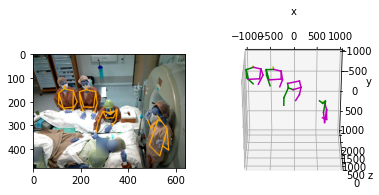

In [52]:

print(persons3D_ann.shape)
def simulateAnnonPlot():
    hy = HydraPose(pose3D = SEFFPOSE)
    hy.persons2D = persons2D_ann[:4]
    hy.persons3DHybrid = persons3D_ann[:4]
    hy.initWindow()
    hy.viz.ax3D.set_xlim(-1000, 1000)
    hy.viz.ax3D.set_ylim(-1000, 1000)
    hy.viz.ax3D.set_zlim(-200, 2200)
    hy.plotPersons(imgs[0].copy(), block=False, mode='MVOR')
simulateAnnonPlot()

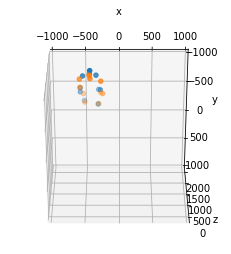

In [59]:
id_ann = 1
id = 3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# X = anns3d[id]['keypoints3D'][0::4]
# Y = anns3d[id]['keypoints3D'][1::4]
# Z = anns3d[id]['keypoints3D'][2::4]
# ax.scatter(X,Y,Z)
ax.scatter(persons[id,:10,0],persons[id,:10,1],persons[id,:10,2])
ax.scatter(persons3D_ann[id_ann,:10,0],persons3D_ann[id_ann,:10,1],persons3D_ann[id_ann,:10,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.set_zlim(-200, 2200)
ax.azim = -90
ax.dist = 10
ax.elev = -60

In [54]:
persons3D_ann[0]

array([[-6.98103739e+00, -4.35361492e+01,  2.26887339e+03],
       [-1.56920652e+01,  1.27159989e+01,  2.40385575e+03],
       [ 1.59950939e+02, -3.02933737e+01,  2.44603584e+03],
       [-1.22298175e+02, -1.65835687e+01,  2.45116987e+03],
       [ 1.25675927e+02, -8.41589943e+01,  2.76471746e+03],
       [-1.38972209e+02, -2.93748380e+01,  2.74470499e+03],
       [ 1.24482251e+02,  1.70866286e+02,  2.49563625e+03],
       [-2.21091623e+02,  2.08138830e+02,  2.37722831e+03],
       [ 4.00171886e+01,  2.79697063e+02,  2.37555543e+03],
       [-2.23969412e+02,  3.43525126e+02,  2.21394318e+03],
       [ 8.48185306e-01,  3.29554694e+02,  2.31701293e+03],
       [-2.02926517e+02,  4.07224502e+02,  2.16891705e+03]])

In [55]:
persons[1,:10]

array([[ 4.24192600e+01, -1.88159101e+01,  2.96679608e+03],
       [ 2.85707518e+01, -5.25141589e+01,  3.10945534e+03],
       [ 1.49163686e+02, -4.93773719e+01,  3.13762809e+03],
       [-1.04149344e+02, -5.78145611e+01,  3.11879707e+03],
       [ 1.05737996e+02,  1.33114658e+02,  3.41320746e+03],
       [-9.86819242e+01,  3.04739223e+02,  3.30232372e+03],
       [ 1.66439711e+02,  2.36216942e+02,  3.04640135e+03],
       [-2.02324960e+02,  2.42663404e+02,  3.15821754e+03],
       [-2.91668815e+00,  3.59931130e+02,  2.98857994e+03],
       [-2.99900364e+02,  5.15357870e+02,  3.14175128e+03]])

In [62]:
np.set_printoptions(suppress=True)
print(persons3D_ann[1,:10]-persons[3,:10])

[[  -7.7540422    52.4183036   -89.95180872]
 [   9.14958451   36.20056875 -132.38549354]
 [  75.497079     58.41784509 -142.28830815]
 [ -47.78894125   27.09061331  -85.24883104]
 [  33.91041787    2.72686464 -162.29840897]
 [  51.07959096   -0.17140389  -99.54694635]
 [  37.00597751   41.01059657  -74.23633121]
 [   1.63698671  -74.07728671 -202.91362618]
 [   8.8877005   -29.33788134  -63.66639706]
 [  11.6300268   -63.97966409 -280.92150624]]
